### **Cargue de datos**


In [1]:
# Important Libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
from pyspark.sql.functions import col, to_date
import pyspark.sql.functions as f
from pyspark.sql.types import NumericType
import os 
from datetime import datetime
from pyspark.sql import types as t
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from pyspark.sql.functions import col

In [2]:
class MySQLConnector:
    def __init__(self, spark: SparkSession, connection_properties: dict, url: str):
        self.spark = spark
        self.properties = connection_properties
        self.url = url

    def get_dataframe(self, sql_query: str):
        """
        Execute a SQL query and return the result as a Spark DataFrame.

        Parameters:
        sql_query (str): SQL query to be executed.

        Returns:
        DataFrame: Resultant DataFrame from the executed SQL query.
        """
        df = self.spark.read.jdbc(
            url=self.url,
            table=sql_query,
            properties=self.properties
        )
        return df

In [3]:
# Utils to create spark object
def create_spark_session(path_jar_driver):
    # Configuración de la sesión de Spark
    conf = SparkConf() \
        .set('spark.driver.extraClassPath', path_jar_driver)

    spark_context = SparkContext(conf=conf)
    sql_context = SQLContext(spark_context)
    spark = sql_context.sparkSession

    return spark


In [4]:
# Given Credentials
db_user = 'Estudiante_65_202415'
db_psswd = 'Estudiante_202010409'

connection_properties = {
    "user": db_user,
    "password": db_psswd,
    "driver": "com.mysql.cj.jdbc.Driver"
}

default_string_connection = 'jdbc:mysql://157.253.236.120:8080/WWImportersTransactional'

In [5]:
# WINDOWS - Compatible with VM  
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

# LINUX users: to download the jar wget https://dev.mysql.com/get/Downloads/Connector-J/mysql-connector-java-8.0.28.tar.gz
#path_jar_driver = '/opt/mysql/lib/mysql-connector-java-8.0.28.jar'

In [7]:
spark = create_spark_session(path_jar_driver)

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [10]:
conn = MySQLConnector(spark=spark, connection_properties=connection_properties, url=default_string_connection)

In [11]:
sql_benefit_planes = 'RaSaTransaccional.FuentePlanesBeneficio_Copia_E'

## **Perfilamiento de datos**

#### Exploración de la Estructura

FuentesPlanesBeneficio_Copia_E

	idPlan_T	identificador del plan
	idTipoBeneficio_T	identificador del tipo de beneficio
	idAreaDeServicio_T	identificador del área de servicio
	idCondicionesDePagoCopago_T	identificador de la condicion de pago Copago
	idCondicionesDePagoCoseguro_T	identificador de la condicion de pago Coseguro
	idProveedor_T	identificador del proveedor del plan
	Fecha	Fecha de oferta del beneficio para ese plan
	idNivelServicio_T	identificador del nivel de servicio
	valorCopago	valor del copago
	valorCoseguro	valor del coseguro
	cantidadLimite	cantidad limite del tipo de beneficio

In [30]:
# Contar el número total de registros en la tabla
total_registros = benefits.count()
print(f"El número total de registros en la tabla es: {total_registros}")


El número total de registros en la tabla es: 36036


In [13]:
benefits  = conn.get_dataframe(sql_benefit_planes)
benefits.show(5)

+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|              640|          10382017|                       34|                         27|                3|16842FL0070128-03|2017-12-31|        16842|          0|           50|            35|
|              225|          31512017|                      238|                         45|                2|29418TX0140002-04|2017-12-31|        29418|          0|            0|          null|
|              190|      

In [31]:
from pyspark.sql.functions import col, count, when

# Obtener el total de registros en la tabla
total_registros = benefits.count()

# Calcular el porcentaje de completitud de cada columna
completitud_columnas = benefits.select([
    (count(when(col(c).isNotNull(), c)) / total_registros * 100).alias(c)
    for c in benefits.columns
])

# Mostrar el porcentaje de completitud de cada columna
completitud_columnas.show()


+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+------------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|IdPlan_T|Fecha|IdProveedor_T|valorCopago|valorCoseguro|    cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+------------------+
|94.21134421134421| 94.33621933621934|                    100.0|                      100.0|            100.0|   100.0|100.0|        100.0|      100.0|        100.0|15.165390165390166|
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+------------------+



De acuerdo con el diccionario proporcionado, se evidencia que cada fila representa un beneficio específico dentro del plan de salud. Dentro de las columnas que pueden ser claves dentro de la base y su objetivo se encuentran:

    IdPlan_T: identifica el plan de salud del beneficio.
    IdTipoBeneficio_T: proporciona el tipo de beneficio (completitud de 94%).
    IdCondicionesServicio_T: identifica el área del servicio.
Por lo tanto, entendemos que cada fila representa un tipo de beneficio ofrecido dentro del plan de salud en una fecha específica y en un área predeterminada.

### **Entendimiento de los datos**

In [19]:
# Obtener la cantidad de valores únicos en cada columna
for column in benefits.columns:
    unique_count = benefits.select(column).distinct().count()
    print(f"Columna '{column}': {unique_count} valores únicos")
    
# Opcional: Muestra los valores únicos para cada columna (esto es útil solo para columnas con pocos valores únicos)
for column in benefits.columns:
    print(f"Valores únicos en la columna '{column}':")
    benefits.select(column).distinct().show(5)  # Muestra hasta 10 valores únicos por columna

Columna 'IdTipoBeneficio_T': 286 valores únicos
Columna 'IdAreaDeServicio_T': 6497 valores únicos
Columna 'IdCondicionDePagoCopago_T': 14 valores únicos
Columna 'IdCondicionDePagoCoseguro_T': 5 valores únicos
Columna 'IdNivelServicio_T': 3 valores únicos
Columna 'IdPlan_T': 393 valores únicos
Columna 'Fecha': 5 valores únicos
Columna 'IdProveedor_T': 125 valores únicos
Columna 'valorCopago': 49 valores únicos
Columna 'valorCoseguro': 25 valores únicos
Columna 'cantidadLimite': 42 valores únicos
Valores únicos en la columna 'IdTipoBeneficio_T':
+-----------------+
|IdTipoBeneficio_T|
+-----------------+
|             1950|
|             1010|
|               65|
|             1840|
|             1360|
+-----------------+
only showing top 5 rows

Valores únicos en la columna 'IdAreaDeServicio_T':
+------------------+
|IdAreaDeServicio_T|
+------------------+
|          21482018|
|          36982017|
|          63022018|
|          27112018|
|          35272018|
+------------------+
only 

1. De acuerdo con lo que evidencia el negocio, nos confirman que tienen 5.409 áreas de servicio; sin embargo, en la fuente evidenciamos 6.497, lo que podría indicar inconsistencias en la fuente o duplicados.
2. El negocio evidencia que las condiciones de copago son 15; sin embargo, se evidencian solo 14, por lo que se debe validar con el negocio si hace falta algún dato.
3. Para IdPlan_T, el negocio nos dice que hay 301 planes para 2017 y 422 para el año 2018, pero se identifican solo 393 valores únicos.
4. Para IdTipoBeneficio_T, el negocio nos dice que hay 170; sin embargo, la fuente muestra 286, por lo que hay que revisar si se tienen duplicados o hay inconsistencias en lo que dice el negocio.
5. Se evidencian solo 5 valores únicos para la fecha, pero en un periodo de tiempo de 2 años, por lo que se deben revisar esas fechas tanto en el formato como con el negocio para validar que sean correctas o si la información se sube en un mismo periodo de tiempo, y por eso tenemos tan pocas fechas.


#### Valores Únicos

In [14]:
# Mostrar la estructura de la tabla y tipos de datos de cada columna
benefits.printSchema()

root
 |-- IdTipoBeneficio_T: long (nullable = true)
 |-- IdAreaDeServicio_T: long (nullable = true)
 |-- IdCondicionDePagoCopago_T: integer (nullable = true)
 |-- IdCondicionDePagoCoseguro_T: integer (nullable = true)
 |-- IdNivelServicio_T: integer (nullable = true)
 |-- IdPlan_T: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- IdProveedor_T: integer (nullable = true)
 |-- valorCopago: integer (nullable = true)
 |-- valorCoseguro: integer (nullable = true)
 |-- cantidadLimite: integer (nullable = true)



Estructura de la Tabla
1. Tenemos variables de tipo long o integer para los IDs.
2. Valores cuantitativos para valorCopago y cantidad.
3. Hay valores catalogados como string, como IdPlan_T y Fecha, que necesitan revisión y deben ser modificados a integer y el tipo de dato correspondiente.

#### Análisis de Valores Nulos

In [15]:
from pyspark.sql.functions import col, when, count

# Conteo de valores nulos en cada columna
null_counts = benefits.select([count(when(col(c).isNull(), c)).alias(c) for c in benefits.columns])
null_counts.show()


+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|IdPlan_T|Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+
|             2086|              2041|                        0|                          0|                0|       0|    0|            0|          0|            0|         30571|
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+



Hay que validar con el negocio dónde se puede obtener la información, teniendo en cuenta que esta es la que nos identifica el tipo de beneficio. El área donde se ofrece el servicio es clave para el análisis de la información.

#### Estadísticas Descriptivas

In [21]:
# Seleccionar solo las columnas numéricas relevantes para estadísticas descriptivas
numeric_columns = ["valorCopago", "valorCoseguro", "cantidadLimite"]

# Generar estadísticas descriptivas para las columnas seleccionadas
benefits.select(numeric_columns).describe().show()


+-------+------------------+------------------+-----------------+
|summary|       valorCopago|     valorCoseguro|   cantidadLimite|
+-------+------------------+------------------+-----------------+
|  count|             36036|             36036|             5465|
|   mean| 9.778416028416029| 24.29279054279054|129.3313815187557|
| stddev|100.41137967701272|36.959755494458506|951.2795862330698|
|    min|                 0|                 0|                1|
|    max|              3500|               100|            30000|
+-------+------------------+------------------+-----------------+



Valor_Copago:
1. El valor promedio de copago es de 9.77.
2. La desviación estándar es bastante relevante respecto al promedio, lo que indica que existe una gran variabilidad en los valores de esta variable.
3. Existen valores de 0, lo que indicaría que hay usuarios que no tienen que pagar por el servicio; sin embargo, vale la pena validar con el negocio si esto es una condición válida.
4. Vale la pena validar si hay errores en las cifras reportadas de copago, ya que el negocio informó que el máximo era de 3.300, pero tenemos registrados valores de 3.500. ¿Es un error?
Valor_Coseguro:
1. El valor promedio de coseguro es de 24.29.
2. La desviación estándar es alta respecto al promedio, lo que indicaría que existe una gran variabilidad en los valores.
3. Existen valores de 0, lo que indicaría que hay usuarios que no tienen que pagar por el seguro; sin embargo, vale la pena validar con el negocio si esto es una condición válida.
Cantidad_Limite:
1. El valor promedio de cantidad límite es de 129, lo que podría indicar la cantidad de unidades permitidas para ciertos beneficios.
2. La desviación estándar es bastante más alta que el promedio, lo que indicaría que los límites varían según el tipo de beneficio que se tiene.
3. Hay servicios que permiten solo 1 beneficio.
4. El valor de 30.000 parece un valor a validar con el negocio para determinar si es posible tener tanta cantidad de unidades para un solo beneficio.


### **Revisión de reglas de negocio:** 

#### Información 1: Las áreas de servicios reportadas cubren todos los condados del país

In [25]:
# Verificar si existen valores nulos en la columna IdAreaDeServicio_T
nulos_area_servicio = benefits.filter(col("IdAreaDeServicio_T").isNull()).count()

if nulos_area_servicio > 0:
    print(f"Existen {nulos_area_servicio} registros con áreas de servicio nulas, lo cual indica datos incompletos en términos de cobertura.")
else:
    print("No existen valores nulos en la columna IdAreaDeServicio_T, por lo que todos los registros tienen una área de servicio asignada.")


Existen 2041 registros con áreas de servicio nulas, lo cual indica datos incompletos en términos de cobertura.


IdAreaDeServicio_T se encuentran 2.041 valores nulos lo que hace que se deba validar la información proporcionada ya que deberia ser un valor que este reportado dentro de la base. 

#### Información 2: Los tipos de beneficios con límite cuantitativo deben tener una cantidadLimite diferente de cero en los planes que los ofrecen.

In [27]:
# Filtrar los registros donde `cantidadLimite` es 0 o nulo
registros_sin_limite = benefits.filter((col("cantidadLimite") == 0) | (col("cantidadLimite").isNull()))

# Contar los registros que no cumplen con la condición
conteo_registros_sin_limite = registros_sin_limite.count()

print(f"La cantidad de registros que no cumplen con la condición de tener un `cantidadLimite` diferente de cero es: {conteo_registros_sin_limite}")

La cantidad de registros que no cumplen con la condición de tener un `cantidadLimite` diferente de cero es: 30571


In [32]:
# Contar registros con cantidadLimite igual a 0
cantidad_limite_cero = benefits.filter(col("cantidadLimite") == 0).count()

# Contar registros con cantidadLimite nulo
cantidad_limite_null = benefits.filter(col("cantidadLimite").isNull()).count()

print(f"Cantidad de registros con cantidadLimite igual a 0: {cantidad_limite_cero}")
print(f"Cantidad de registros con cantidadLimite nulo: {cantidad_limite_null}")


Cantidad de registros con cantidadLimite igual a 0: 0
Cantidad de registros con cantidadLimite nulo: 30571


Se evidencia en la base que cantidadLimite tiene nulos, lo que representa un problema para la completitud de la base y no cumple con lo definido por el negocio.

#### Información 3: Las fuentes FuenteAreasDeServicio_Copia_E y FuenteTiposBeneficio_Copia_E comparten información de los años 2017 al 2019

In [41]:
from pyspark.sql.functions import year

# Extraer el año de la columna `Fecha` y contar los registros por año
registros_por_anio = benefits.withColumn("Anio", year(col("Fecha"))) \
                             .groupBy("Anio") \
                             .count() \
                             .orderBy("Anio")

# Mostrar el conteo de registros por año
registros_por_anio.show()


+----+-----+
|Anio|count|
+----+-----+
|null| 2056|
|1920| 2052|
|2017|16134|
|2018|15794|
+----+-----+



#### Información 4: La empresa comparte 5409 áreas de servicios y 170 tipos de beneficios.

In [46]:
# Contar los valores únicos en la columna `IdAreaDeServicio_T`
areas_servicio_unicas = benefits.select("IdAreaDeServicio_T").distinct().count()

# Contar los valores únicos en la columna `IdTipoBeneficio_T`
tipos_beneficio_unicos = benefits.select("IdTipoBeneficio_T").distinct().count()

# Valores esperados
areas_servicio_esperadas = 5409
tipos_beneficio_esperados = 170

# Validar áreas de servicio
if areas_servicio_unicas == areas_servicio_esperadas:
    print(f"La cantidad de áreas de servicio es correcta: {areas_servicio_unicas} áreas únicas.")
else:
    print(f"La cantidad de áreas de servicio es {areas_servicio_unicas}, lo cual no coincide con las {areas_servicio_esperadas} áreas esperadas.")

# Validar tipos de beneficio
if tipos_beneficio_unicos == tipos_beneficio_esperados:
    print(f"La cantidad de tipos de beneficios es correcta: {tipos_beneficio_unicos} tipos únicos.")
else:
    print(f"La cantidad de tipos de beneficios es {tipos_beneficio_unicos}, lo cual no coincide con los {tipos_beneficio_esperados} tipos esperados.")


La cantidad de áreas de servicio es 6497, lo cual no coincide con las 5409 áreas esperadas.
La cantidad de tipos de beneficios es 286, lo cual no coincide con los 170 tipos esperados.


Se debe validar con el negocio la información proporcionada, ya que la cantidad de áreas y tipos de beneficios no coinciden. Por lo tanto, es necesario verificar que toda la información suministrada sea correcta o entender por qué puedo tener más cantidades.

#### Información 5: El valor máximo Copago y Coseguro para el año 2018 es respectivamente 3300 y 100.

In [52]:
# Contar los registros de 2018 donde `valorCopago` es mayor que 3,300
copago_incorrecto = benefits.filter(
    (col("Fecha").between("2018-01-01", "2018-12-31")) &
    (col("valorCopago") > 3300)
).count()

# Contar los registros de 2018 donde `valorCoseguro` es mayor que 100
coseguro_incorrecto = benefits.filter(
    (col("Fecha").between("2018-01-01", "2018-12-31")) &
    (col("valorCoseguro") > 100)
).count()

print(f"Cantidad de registros con `valorCopago` > 3300 en 2018: {copago_incorrecto}")
print(f"Cantidad de registros con `valorCoseguro` > 100 en 2018: {coseguro_incorrecto}")


Cantidad de registros con `valorCopago` > 3300 en 2018: 8
Cantidad de registros con `valorCoseguro` > 100 en 2018: 0


In [50]:
# Mostrar solo las columnas `valorCopago` y `valorCoseguro` de los registros que no cumplen con la condición en 2018
copago_coseguro_incorrecto.select("valorCopago", "valorCoseguro").show(8)


+-----------+-------------+
|valorCopago|valorCoseguro|
+-----------+-------------+
|       3500|            0|
|       3500|            0|
|       3500|            0|
|       3500|            0|
|       3500|            0|
|       3500|            0|
|       3500|            0|
|       3500|            0|
+-----------+-------------+



De acuerdo con la información proporcionada, tenemos solo 8 registros que no cumplen con las reglas del negocio para valorCopago. Se requiere validar con el negocio si esta información es correcta o si se deben hacer ajustes en la información.

#### Información 6: Además, les comparte información de 301 planes para 2017 y de 422 para el año 2018.

In [56]:
# Contar los planes únicos por año
planes_2017 = benefits.filter(col("Fecha").between("2017-01-01", "2017-12-31")).select("IdPlan_T").distinct().count()
planes_2018 = benefits.filter(col("Fecha").between("2018-01-01", "2018-12-31")).select("IdPlan_T").distinct().count()

print(f"Planes únicos en 2017: {planes_2017}")
print(f"Planes únicos en 2018: {planes_2018}")

# Contar el número total de planes únicos en la columna `IdPlan_T`
total_planes_unicos = benefits.select("IdPlan_T").distinct().count()

print(f"El número total de planes únicos en la tabla es: {total_planes_unicos}")



Planes únicos en 2017: 203
Planes únicos en 2018: 286
El número total de planes únicos en la tabla es: 393


La cantidad de planes por año reportados por el negocio no corresponde a la información proporcionada. Tenemos una menor cantidad para cada uno de los años mencionados.

#### Información 6: Existen 15 y 5 diferentes condiciones de copago y coseguro respectivamente.

In [59]:
# Contar los valores únicos en `IdCondicionDePagoCopago_T`
copago_unicos = benefits.select("IdCondicionDePagoCopago_T").distinct().count()

# Contar los valores únicos en `IdCondicionDePagoCoseguro_T`
coseguro_unicos = benefits.select("IdCondicionDePagoCoseguro_T").distinct().count()

# Valores esperados
copago_esperado = 15
coseguro_esperado = 5

# Validar las condiciones de copago
if copago_unicos == copago_esperado:
    print(f"La cantidad de condiciones de copago es correcta: {copago_unicos} condiciones únicas.")
else:
    print(f"La cantidad de condiciones de copago es {copago_unicos}, lo cual no coincide con las {copago_esperado} condiciones esperadas.")

# Validar las condiciones de coseguro
if coseguro_unicos == coseguro_esperado:
    print(f"La cantidad de condiciones de coseguro es correcta: {coseguro_unicos} condiciones únicas.")
else:
    print(f"La cantidad de condiciones de coseguro es {coseguro_unicos}, lo cual no coincide con las {coseguro_esperado} condiciones esperadas.")


La cantidad de condiciones de copago es 14, lo cual no coincide con las 15 condiciones esperadas.
La cantidad de condiciones de coseguro es correcta: 5 condiciones únicas.


Se debe validar con el negocio por qué nos hace falta un copago o por qué no se incluyó.

### **Análisis de calidad de datos**

#### **Completitud y Validez de los datos**

#### Completitud

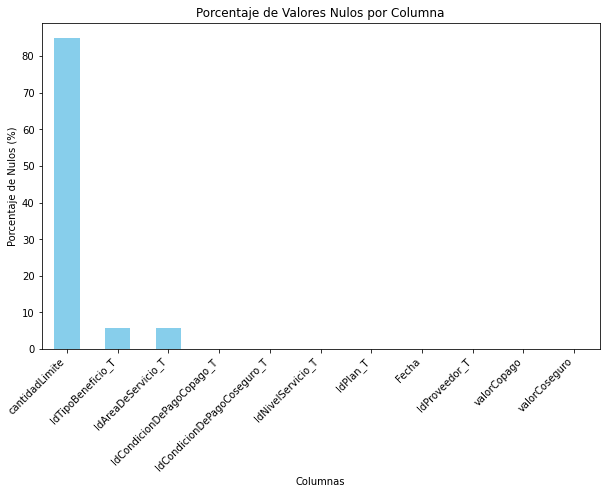

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir el DataFrame de PySpark a Pandas
benefits_pd = benefits.toPandas()

# Calcular el porcentaje de valores nulos por columna
porcentaje_nulos = benefits_pd.isnull().mean() * 100

# Crear un gráfico de barras del porcentaje de nulos por columna
plt.figure(figsize=(10, 6))
porcentaje_nulos.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Valores Nulos por Columna')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Nulos (%)')
plt.xticks(rotation=45, ha='right')
plt.show()


1. CantidadLimite tiene un 80% de valores nulos, lo que representa un problema para el negocio, ya que ellos definen: "Los tipos de beneficios con límite cuantitativo deben tener una cantidadLimite diferente de cero en los planes que los ofrecen", lo que no permite validar que este límite se esté cumpliendo de acuerdo con el beneficio a evaluar, teniendo en cuenta que afecta la completitud. Se debe validar con el negocio si hay forma de obtener estos datos, ya que son clave para el análisis.

2. IdTipoBeneficio_T y IdAreaDeServicio_T tienen menos del 10% de datos nulos. Es muy relevante poder tener el 100% de los datos, ya que no se puede identificar el tipo de beneficio y no se puede especificar el área a la que pertenece. Estas son claves en los análisis y afectan la completitud.

#### **Consistencia y Exactitud de los datos**

##### Consistencia en llaves:
1. IdPlan_T debería estar en todos los registros como llave e identificador único y sin duplicados.
2. IdTipoBeneficio_T e IdAreaDeServicio_T también deberían estar en todos los registros.

In [65]:
# Verificar registros con valores nulos en llaves principales
llaves_nulas = benefits.filter(
    col("IdPlan_T").isNull() | col("IdTipoBeneficio_T").isNull() | col("IdAreaDeServicio_T").isNull()
)
llaves_nulas_count = llaves_nulas.count()

print(f"Registros con llaves principales nulas (IdPlan_T, IdTipoBeneficio_T, IdAreaDeServicio_T): {llaves_nulas_count}")
llaves_nulas.show(5)


Registros con llaves principales nulas (IdPlan_T, IdTipoBeneficio_T, IdAreaDeServicio_T): 4127
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|     Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+----------+-------------+-----------+-------------+--------------+
|             null|         107352017|                      238|                         45|                2|93332GA0710044-00|2017-12-31|        93332|          0|            0|          null|
|             null|          85992018|                      238|                         45|                2|71933PA0020003-

Se deben validar 4.127 registros que tienen nulos en las llaves principales y que son esenciales para analizar la base de beneficios.

#### Consistencia en Valores Numéricos

In [76]:
from pyspark.sql.functions import col

# Verificar valores negativos en `valorCopago` y `valorCoseguro`
copago_coseguro_negativos = benefits.filter((col("valorCopago") < 0) | (col("valorCoseguro") < 0))
copago_coseguro_negativos_count = copago_coseguro_negativos.count()

print(f"Registros con valores negativos en `valorCopago` o `valorCoseguro`: {copago_coseguro_negativos_count}")
copago_coseguro_negativos.show()

# Verificar valores en 2018 que excedan los límites para `valorCopago` y `valorCoseguro`
copago_coseguro_excedentes_2018 = benefits.filter(
    (col("Fecha").between("2018-01-01", "2018-12-31")) &
    ((col("valorCopago") > 3300) | (col("valorCoseguro") > 100))
)
copago_coseguro_excedentes_2018_count = copago_coseguro_excedentes_2018.count()

print(f"Registros en 2018 con `valorCopago` > 3300 o `valorCoseguro` > 100: {copago_coseguro_excedentes_2018_count}")
copago_coseguro_excedentes_2018.select("Fecha", "valorCopago", "valorCoseguro").show()

# Verificar `cantidadLimite` con valores nulos o cero
cantidad_limite_invalida = benefits.filter((col("cantidadLimite").isNull()) | (col("cantidadLimite") == 0))
cantidad_limite_invalida_count = cantidad_limite_invalida.count()  # Ejecutar el método `count()` correctamente

print(f"Registros con `cantidadLimite` inválido (nulo o cero): {cantidad_limite_invalida_count}")

# Mostrar algunos ejemplos de los registros con `cantidadLimite` inválido, incluyendo las columnas adicionales solicitadas
cantidad_limite_invalida.select("IdPlan_T", "IdTipoBeneficio_T", "IdAreaDeServicio_T", "cantidadLimite").show(5)


Registros con valores negativos en `valorCopago` o `valorCoseguro`: 0
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|IdPlan_T|Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+

Registros en 2018 con `valorCopago` > 3300 o `valorCoseguro` > 100: 8
+----------+-----------+-------------+
|     Fecha|valorCopago|valorCoseguro|
+----------+-----------+-------------+
|2018-12-31|      

1. No se encuentran valores negativos para las variables numéricas, por lo que se verifica que no hay inconsistencias en estas columnas.
2. Se encuentran 8 registros a validar con el negocio para entender por qué el valor del copago es superior a la información dada por el negocio.
2. Se presenta un ejemplo de cantidadLimite nulo relacionado con las llaves principales, con el fin de darle al negocio una idea de los registros que tienen esa condición para lograr la completitud de los datos.


#### Consistencia en Fechas

In [79]:
from pyspark.sql.functions import col, regexp_extract

# Extraer diferentes patrones de fecha comunes (ejemplos: YYYY-MM-DD, DD-MM-YYYY, etc.)
# Crear una columna temporal que intente capturar estos patrones
benefits = benefits.withColumn(
    "FormatoFecha",
    regexp_extract(col("Fecha"), r'(\d{4}-\d{2}-\d{2})|(\d{2}-\d{2}-\d{4})|(\w{3} \d{2},\d{4})', 0)
)

# Ver los formatos únicos en la columna `FormatoFecha`
formatos_fecha = benefits.select("FormatoFecha").distinct()
formatos_fecha.show(truncate=False)



+------------+
|FormatoFecha|
+------------+
|2018-12-31  |
|Dec 31,2017 |
|Dec 31,2018 |
|2017-12-31  |
|1920-12-31  |
+------------+



1. Se evidencian diferentes formatos de fecha dentro de la base, por lo que se deben normalizar en DD-MM-YYYY.
2. Se debe validar con el negocio por qué aparecen fechas de 1920, ya que no corresponden con el periodo de análisis y esto afecta la calidad de los datos.
3. Se debe validar por qué no aparece 2019 en la base.

#### Consistencia en Condiciones de Pago

In [69]:
# Verificar valores únicos en `IdCondicionDePagoCopago_T` y `IdCondicionDePagoCoseguro_T`
condiciones_copago_unicas = benefits.select("IdCondicionDePagoCopago_T").distinct().count()
condiciones_coseguro_unicas = benefits.select("IdCondicionDePagoCoseguro_T").distinct().count()

print(f"Condiciones de Copago Únicas: {condiciones_copago_unicas} (esperado: 15)")
print(f"Condiciones de Coseguro Únicas: {condiciones_coseguro_unicas} (esperado: 5)")


Condiciones de Copago Únicas: 14 (esperado: 15)
Condiciones de Coseguro Únicas: 5 (esperado: 5)


e debe validar con el negocio por qué nos falta 1 condición de copago.

#### Consistencia en registros duplicados 

In [80]:
# Agrupar por todas las columnas y contar registros duplicados
duplicados_todas_columnas = benefits.groupBy(benefits.columns).count().filter(col("count") > 1)

# Contar el número total de registros duplicados
total_duplicados_todas_columnas = duplicados_todas_columnas.count()

print(f"Cantidad total de registros completamente duplicados (todas las columnas): {total_duplicados_todas_columnas}")

# Mostrar algunos ejemplos de registros completamente duplicados
duplicados_todas_columnas.show(truncate=False)


Cantidad total de registros completamente duplicados (todas las columnas): 8342
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------+--------------+------------+-----+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|IdPlan_T         |Fecha      |IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|FormatoFecha|count|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------+--------------+------------+-----+
|830              |67552018          |238                      |36                         |1                |53901AZ1420020-00|2018-12-31 |53901        |30         |0            |1             |2018-12-31  |2    |
|330              |80662018          |187                   

Se identifican 8,342 registros duplicados que coinciden exactamente en todas sus columnas, por lo que hay que considerar eliminar estos registros para reducir el ruido en la base.

#### **Cardinalidad**

In [84]:
# Calcular y mostrar la cardinalidad para todas las columnas en el DataFrame
for columna in benefits.columns:
    cardinalidad = benefits.select(columna).distinct().count()
    print(f"Cardinalidad de la columna `{columna}`: {cardinalidad}")


Cardinalidad de la columna `IdTipoBeneficio_T`: 286
Cardinalidad de la columna `IdAreaDeServicio_T`: 6497
Cardinalidad de la columna `IdCondicionDePagoCopago_T`: 14
Cardinalidad de la columna `IdCondicionDePagoCoseguro_T`: 5
Cardinalidad de la columna `IdNivelServicio_T`: 3
Cardinalidad de la columna `IdPlan_T`: 393
Cardinalidad de la columna `Fecha`: 5
Cardinalidad de la columna `IdProveedor_T`: 125
Cardinalidad de la columna `valorCopago`: 49
Cardinalidad de la columna `valorCoseguro`: 25
Cardinalidad de la columna `cantidadLimite`: 42
Cardinalidad de la columna `FormatoFecha`: 5


In [85]:
# Definir umbral para alta y baja cardinalidad
umbral_cardinalidad = 20

# Inicializar listas para almacenar las columnas de alta y baja cardinalidad
alta_cardinalidad = []
baja_cardinalidad = []

# Calcular la cardinalidad para cada columna y clasificarla
for columna in benefits.columns:
    cardinalidad = benefits.select(columna).distinct().count()
    if cardinalidad > umbral_cardinalidad:
        alta_cardinalidad.append((columna, cardinalidad))
    else:
        baja_cardinalidad.append((columna, cardinalidad))

# Mostrar resultados
print("Columnas de Alta Cardinalidad:")
for columna, cardinalidad in alta_cardinalidad:
    print(f"  - {columna}: {cardinalidad} valores únicos")

print("\nColumnas de Baja Cardinalidad:")
for columna, cardinalidad in baja_cardinalidad:
    print(f"  - {columna}: {cardinalidad} valores únicos")


Columnas de Alta Cardinalidad:
  - IdTipoBeneficio_T: 286 valores únicos
  - IdAreaDeServicio_T: 6497 valores únicos
  - IdPlan_T: 393 valores únicos
  - IdProveedor_T: 125 valores únicos
  - valorCopago: 49 valores únicos
  - valorCoseguro: 25 valores únicos
  - cantidadLimite: 42 valores únicos

Columnas de Baja Cardinalidad:
  - IdCondicionDePagoCopago_T: 14 valores únicos
  - IdCondicionDePagoCoseguro_T: 5 valores únicos
  - IdNivelServicio_T: 3 valores únicos
  - Fecha: 5 valores únicos
  - FormatoFecha: 5 valores únicos


Se dividen las columnas en alta y baja cardinalidad con el objetivo de entender cuáles representan una gran variedad de datos y cuáles son más útiles para analizar a la hora de querer segmentar la información, mientras que las de baja cardinalidad nos ayudarán en la segmentación y análisis descriptivos.

### **Analisis Descriptivo**

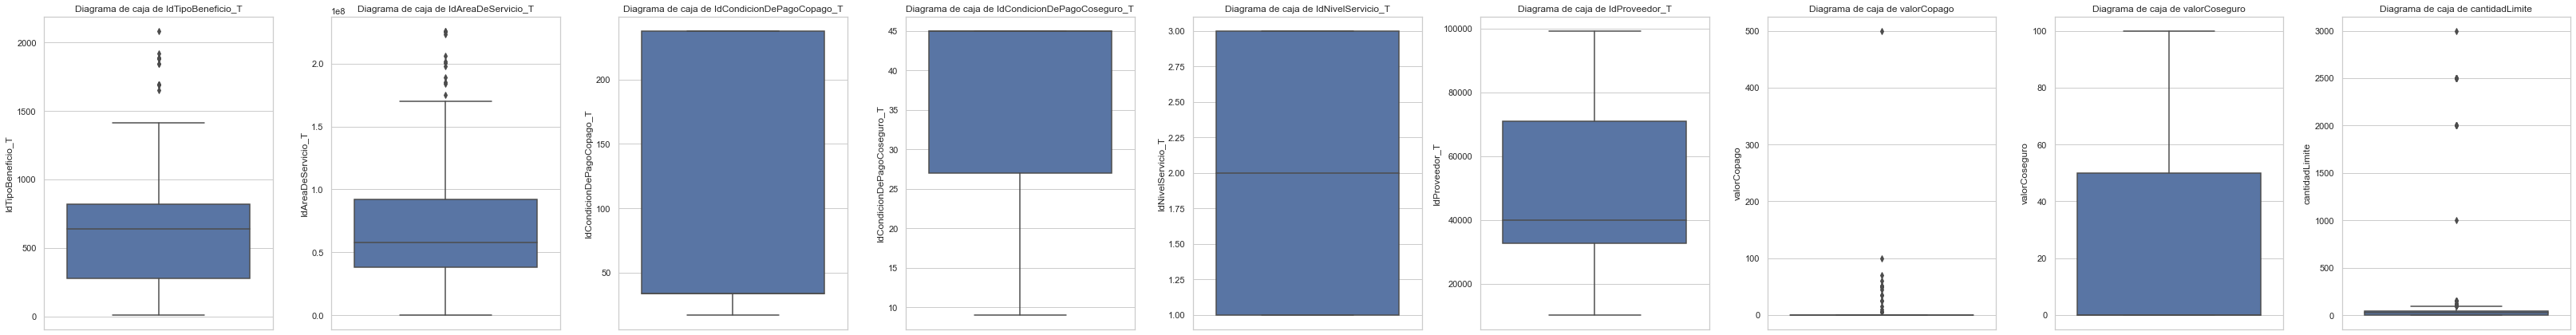

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import NumericType

def plot_numeric_box_plots(spark_df, sample_fraction=0.1):
    """
    Genera diagramas de caja para todas las columnas numéricas de un DataFrame de Spark.

    Parámetros:
    - spark_df: DataFrame de Spark.
    - sample_fraction: Fracción de datos a muestrear (valor entre 0 y 1). Por defecto es 1.0 (todos los datos).
    Retorna:
    - None. La función muestra los diagramas de caja.
    """
    # Identificar las columnas numéricas
    numeric_columns = [field.name for field in spark_df.schema.fields if isinstance(field.dataType, NumericType)]

    if not numeric_columns:
        print("El DataFrame no contiene columnas numéricas.")
        return

    # Muestrear los datos si es necesario
    if sample_fraction < 1.0:
        spark_df = spark_df.sample(fraction=sample_fraction)

    # Seleccionar solo las columnas numéricas
    spark_numeric_df = spark_df.select(*numeric_columns)

    # Convertir a Pandas DataFrame para graficar
    pandas_df = spark_numeric_df.toPandas()
    pandas_df = pandas_df.dropna()  # Eliminar filas con valores nulos

    sns.set(style="whitegrid")

    num_columns = len(numeric_columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(5 * num_columns, 6))

    if num_columns == 1:
        axes = [axes]

    # Generar diagramas de caja para cada columna numérica
    for ax, column in zip(axes, numeric_columns):
        sns.boxplot(y=pandas_df[column], ax=ax)
        ax.set_title(f'Diagrama de caja de {column}')
        ax.set_ylabel(column)
        ax.set_xlabel('')

    plt.tight_layout()
    plt.show()

# Llamar a la función con tu DataFrame de Spark
plot_numeric_box_plots(benefits, sample_fraction=0.1)  # Ajusta sample_fraction según necesites


1. IdTipoBeneficio: Se observa que existe diversidad de tipos de beneficios. Se deben validar los outliers que muestran valores altos para entender si son correctos o por qué presentan estos valores tan altos. ¿Son casos especiales?

2. IdAreaDeServicio_T: Se observa que existe diversidad en las áreas de servicio, con valores altos. Por lo tanto, los outliers que muestran valores altos se deben validar para entender por qué algunas áreas pueden tener valores altos.

3. IdCondicionDePagoCopago_T: Se observa que la mayoría de los valores se encuentran dentro del rango. No se observan outliers, lo que indicaría una buena consistencia en los valores de las condiciones de pago.

4. ValorCopago: Se observa que la mayoría de los datos se encuentran en la parte baja; sin embargo, se evidencian algunos outliers importantes que deben ser validados para determinar si muestran la cifra correcta, si de acuerdo a las reglas de negocio pueden tener ese valor o si corresponde a un error.

5. CantidadLimite: Tiene varios outliers a pesar de que la mayoría de sus datos se encuentran en la parte baja. Se deben validar si estos valores son correctos, por qué la cantidad límite puede tener valores tan dispersos y a qué hacen referencia. ¿Es alguna condición especial?

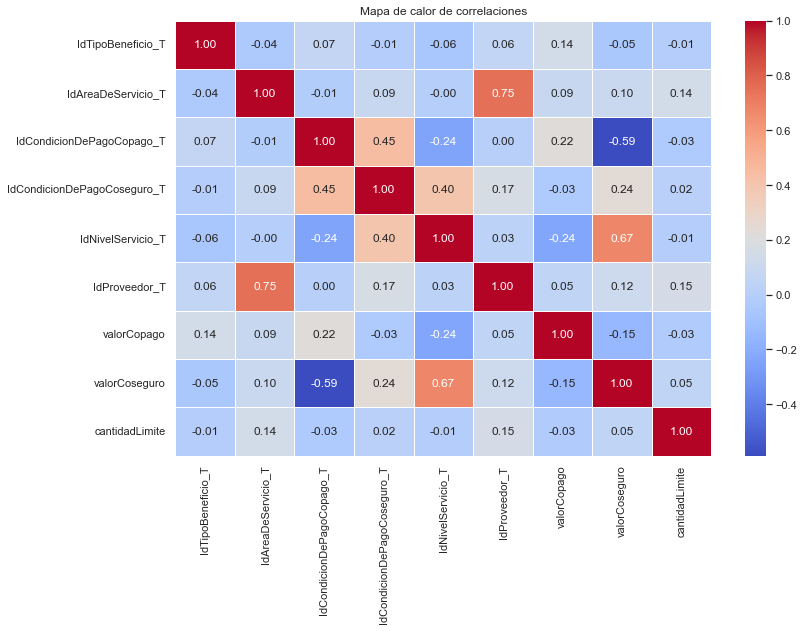

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import NumericType

def plot_correlation_heatmap(spark_df, sample_fraction=1.0):
    """
    Genera un mapa de calor de correlaciones para todas las columnas numéricas de un DataFrame de Spark.

    Parámetros:
    - spark_df: DataFrame de Spark.
    - sample_fraction: Fracción de datos a muestrear (valor entre 0 y 1). Por defecto es 1.0 (todos los datos).

    Retorna:
    - None. La función muestra el mapa de calor de correlaciones.
    """
    # Identificar las columnas numéricas
    numeric_columns = [field.name for field in spark_df.schema.fields if isinstance(field.dataType, NumericType)]

    if not numeric_columns:
        print("El DataFrame no contiene columnas numéricas.")
        return

    # Muestrear los datos si es necesario
    if sample_fraction < 1.0:
        spark_df = spark_df.sample(fraction=sample_fraction)

    # Seleccionar solo las columnas numéricas
    spark_numeric_df = spark_df.select(*numeric_columns)

    # Convertir a Pandas DataFrame para graficar
    pandas_df = spark_numeric_df.toPandas()
    pandas_df = pandas_df.dropna()  # Eliminar filas con valores nulos

    # Calcular la matriz de correlación
    corr_matrix = pandas_df.corr()

    # Crear el mapa de calor
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Mapa de calor de correlaciones')
    plt.show()

# Llamar a la función con tu DataFrame de Spark
plot_correlation_heatmap(benefits, sample_fraction=0.1)  # Ajusta sample_fraction según necesites


1. IdNivelServicio_T y valorCoseguro: presentan una correlación positiva fuerte, lo que indica que a medida que aumenta el nivel de servicio, también aumenta el valor del coseguro. Se esperaría que esto fuera así.

2. IdCondicionDePagoCoseguro_T y valorCoseguro: presentan una correlación positiva fuerte, lo que indica que la condición de pago del coseguro influye en el valor del coseguro.

3. valorCopago y valorCoseguro: presentan una correlación negativa, lo que indicaría que los copagos más altos podrían tener una condición de coseguro más baja.

### 1. Análisis sobre Comportamiento Desleal de Proveedores

##### 1.a: Dado un proveedor o grupo de proveedores si tiene o ha tenido un comportamiento desleal?
##### 1.b: Dado un rango de fechas se identifican proveedores con comportamientos desleales. Un comportamiento desleal corresponde a proveedores que brinden planes con el mismo tipo de beneficio cuyo valor de copago o coseguro evidencian diferencias mayores al 20%"

1. Para este análisis se tienen en cuenta las variables "IdProveedor_T", "IdTipoBeneficio_T", "valorCopago" y "valorCoseguro" para el mismo beneficio.
2. Se denomina a un proveedor desleal cuando la diferencia entre los valores máximo y mínimo de copago o coseguro para un tipo de beneficio excede el 20%.

#####  Verificar Datos Completos en las Variables Clave

In [107]:
from pyspark.sql.functions import col, sum

# Lista de columnas clave
columnas_clave = ["IdProveedor_T", "IdTipoBeneficio_T", "valorCopago", "valorCoseguro"]

# Contar valores nulos en cada columna
valores_nulos = benefits.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in columnas_clave]
)

# Mostrar cantidad de valores nulos en cada columna clave
valores_nulos.show()


+-------------+-----------------+-----------+-------------+
|IdProveedor_T|IdTipoBeneficio_T|valorCopago|valorCoseguro|
+-------------+-----------------+-----------+-------------+
|            0|             2086|          0|            0|
+-------------+-----------------+-----------+-------------+



Para este análisis se requiere que IdTipoBeneficio_T tenga completitud en los datos, por lo que hay que limpiarlo, imputarlo o traerlo de otra base.

##### Verificar si se pueden hacer cálculos de Mínimos, Máximos y Diferencias Porcentuales

In [108]:
# Verificar si existen valores no numéricos o negativos en valorCopago y valorCoseguro
valores_fuera_rango = benefits.filter(
    (col("valorCopago") < 0) | (col("valorCoseguro") < 0)
)

# Contar valores fuera de rango y mostrar los primeros registros para revisión
print("Cantidad de registros con valores fuera de rango:")
print(valores_fuera_rango.count())
valores_fuera_rango.show()


Cantidad de registros con valores fuera de rango:
0
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|IdPlan_T|Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|FormatoFecha|
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+------------+
+-----------------+------------------+-------------------------+---------------------------+-----------------+--------+-----+-------------+-----------+-------------+--------------+------------+



No existen valores anormales y fuera del rango que no permitan realizar los cálculos de mínimos, máximos y diferencias porcentuales.

##### Verificar la Estructura y Rango de Fechas

In [111]:
from pyspark.sql.functions import to_date, year

# Convertir la columna de fecha a un formato de fecha, suponiendo que la columna de fecha se llama "Fecha"
benefits = benefits.withColumn("Fecha", to_date(col("Fecha"), "yyyy-MM-dd"))

# Verificar si hay fechas nulas después de la conversión (fechas en formato incorrecto se convertirán a nulo)
fechas_nulas = benefits.filter(col("Fecha").isNull())
print("Cantidad de registros con fechas inválidas:")
print(fechas_nulas.count())
fechas_nulas.show()

# Verificar el rango de fechas, mostrando el año mínimo y máximo
benefits.select(year("Fecha").alias("Año")).agg(
    min("Año").alias("Año mínimo"),
    max("Año").alias("Año máximo")
).show()


Cantidad de registros con fechas inválidas:
2056
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+-----+-------------+-----------+-------------+--------------+------------+
|IdTipoBeneficio_T|IdAreaDeServicio_T|IdCondicionDePagoCopago_T|IdCondicionDePagoCoseguro_T|IdNivelServicio_T|         IdPlan_T|Fecha|IdProveedor_T|valorCopago|valorCoseguro|cantidadLimite|FormatoFecha|
+-----------------+------------------+-------------------------+---------------------------+-----------------+-----------------+-----+-------------+-----------+-------------+--------------+------------+
|              255|          30292017|                      238|                         45|                2|29418TX0140002-04| null|        29418|          0|            0|          null| Dec 31,2017|
|               15|         103882017|                      238|                         45|                1|91762NJ0070093-00| null|     

Para realizar el análisis con el campo de fecha se debe:

1. Normalizar la fecha a solo dd-MM-yyyy.
2. Existen 2,056 registros que no tienen fecha y que deben ser validados para el análisis, y se debe determinar si pueden ser imputados o si se pueden traer de otras tablas.
3. Se deben validar los registros que aparecen con fecha de 1920, ya que no parecen estar acordes a lo reportado por el negocio.

Recomendaciones:
1. Examinar el comportamiento desleal de los proveedores a lo largo del tiempo es relevante; sin embargo, se recomienda validar el comportamiento por meses para identificar si hay temporadas en las que este comportamiento sea más recurrente y así poder tomar medidas.
2. Se recomienda identificar y segmentar por tipo de proveedores para determinar si hay un grupo específico que presente comportamientos desleales. Asimismo, realizar el mismo ejercicio para identificar proveedores con buenas prácticas y aplicarlas a aquellos que no cumplen.
3. Identificar si algún tipo de beneficio presenta en mayor medida prácticas desleales.
4. Evaluar e identificar el impacto de eliminar a los proveedores desleales de los planes de beneficios.
5. Se debe tener la información completa de IdTipoBeneficio_T antes de empezar con el análisis o traer algún otro campo que nos permita realizar el análisis por tipo de beneficio.
6. Se recomienda construir un modelo predictivo que nos permita identificar qué proveedores tienen mayor propensión a ser desleales, basados en los comportamientos históricos.

### 2. Analisis sobre Cobertura de planes

##### 2.a: Dado un rango de años, mostrar el nivel de cobertura de los planes con respecto a las áreas de servicio
##### 2.b ¿Se ha logrado una cobertura total de los proveedores, cubriendo con sus planes TODAS las áreas de servicio?
##### 2.c: ¿Han existido áreas de servicios que sean cubiertas, a nivel de planes, por menos de dos proveedores?"

1. Para este análisis se tienen en cuenta las variables "IdAreaDeServicio_T", "IdPlan_T", "IdProveedor_T" y "Fecha" para el mismo beneficio.
2. Variables opcionales: "valorCopago" y "valorCoseguro" para el mismo beneficio.

#####  Verificar Datos Completos en las Variables Clave

In [116]:
from pyspark.sql.functions import col, sum

# Lista de columnas clave para validar
columnas_clave = ["IdAreaDeServicio_T", "IdPlan_T", "IdProveedor_T", "Fecha"]

# Contar valores nulos en cada columna
valores_nulos = benefits.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in columnas_clave]
)

# Mostrar la cantidad de valores nulos en cada columna clave
valores_nulos.show()


+------------------+--------+-------------+-----+
|IdAreaDeServicio_T|IdPlan_T|IdProveedor_T|Fecha|
+------------------+--------+-------------+-----+
|              2041|       0|            0| 2056|
+------------------+--------+-------------+-----+



Para este análisis se requiere que IdAreaDeServicio_T y Fecha tengan completitud en los datos, por lo que hay que limpiarlos, imputarlos o traerlos de otra base para poder hacer un análisis de la cobertura de los planes versus las áreas de servicio.

In [117]:
# Contar la cantidad de áreas de servicio y la cantidad de proveedores únicos
total_areas = benefits.select("IdAreaDeServicio_T").distinct().count()
total_proveedores = benefits.select("IdProveedor_T").distinct().count()

# Obtener las áreas de servicio que no tienen planes
areas_sin_planes = benefits.groupBy("IdAreaDeServicio_T").agg(
    count("IdPlan_T").alias("Cantidad_Planes")
).filter(col("Cantidad_Planes") == 0)

# Mostrar áreas de servicio sin planes
areas_sin_planes.show()

# Verificar si hay áreas sin planes
cobertura_total = areas_sin_planes.count() == 0
print(f"¿Se ha logrado una cobertura total de los proveedores? {'Sí' if cobertura_total else 'No'}")


+------------------+---------------+
|IdAreaDeServicio_T|Cantidad_Planes|
+------------------+---------------+
+------------------+---------------+

¿Se ha logrado una cobertura total de los proveedores? Sí


Para este análisis se tiene una completitud del 100% de la información para realizar el análisis de área de servicio versus la cantidad de proveedores.

In [120]:
from pyspark.sql.functions import col, count, countDistinct, sum

# 1. Validar la completitud de las variables clave
columnas_clave = ["IdAreaDeServicio_T", "IdProveedor_T"]

# Contar valores nulos en cada columna clave
valores_nulos = benefits.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in columnas_clave]
)

# Mostrar la cantidad de valores nulos en cada columna clave
print("Cantidad de valores nulos en columnas clave:")
valores_nulos.show()

# 2. Verificar que las áreas de servicio y proveedores tengan datos válidos
# Contar el total de áreas de servicio
total_areas_servicio = benefits.select("IdAreaDeServicio_T").distinct().count()
print(f"Total de áreas de servicio: {total_areas_servicio}")

# Contar el total de proveedores únicos
total_proveedores = benefits.select("IdProveedor_T").distinct().count()
print(f"Total de proveedores: {total_proveedores}")

# 3. Contar la cantidad de proveedores que cubren cada área de servicio
cobertura_proveedores = benefits.groupBy("IdAreaDeServicio_T").agg(
    countDistinct("IdProveedor_T").alias("Cantidad_Proveedores")
)

# 4. Filtrar áreas de servicio cubiertas por menos de dos proveedores
areas_bajo_cobertura = cobertura_proveedores.filter(col("Cantidad_Proveedores") < 2)

# Contar áreas de servicio con menos de dos proveedores
cantidad_areas_bajo_cobertura = areas_bajo_cobertura.count()

# 5. Mostrar áreas de servicio con menos de dos proveedores
print("Áreas de servicio cubiertas por menos de dos proveedores:")
areas_bajo_cobertura.show()

# 6. Mostrar el resultado de los totales
print(f"\nCantidad de áreas de servicio cubiertas por menos de dos proveedores: {cantidad_areas_bajo_cobertura}")


Cantidad de valores nulos en columnas clave:
+------------------+-------------+
|IdAreaDeServicio_T|IdProveedor_T|
+------------------+-------------+
|              2041|            0|
+------------------+-------------+

Total de áreas de servicio: 6497
Total de proveedores: 125
Áreas de servicio cubiertas por menos de dos proveedores:
+------------------+--------------------+
|IdAreaDeServicio_T|Cantidad_Proveedores|
+------------------+--------------------+
|          63022018|                   1|
|          35022018|                   1|
|         103212018|                   1|
|          47882017|                   1|
|          35452018|                   1|
|         109832017|                   1|
|         137594035|                   1|
|          21482018|                   1|
|          22082018|                   1|
|         109312017|                   1|
|         175124036|                   1|
|          27112018|                   1|
|          80582018|            

Se puede realizar el análisis de áreas de servicio con menos de 2 proveedores; sin embargo, se debe tener completitud en los datos, por lo que hay que limpiarlos, imputarlos o traerlos de otra base.

Recomendaciones:
1. Examinar el comportamiento de la cobertura de planes es relevante; sin embargo, se recomienda que antes de iniciar el análisis, se genere la completitud de datos de IdAreaDeServicio_T y Fecha.
2. Analizar cuántos proveedores cubren cada una de las áreas de servicio para identificar si hay zonas con mucha densidad y otras con menos, con el fin de optimizar las áreas por tipo de beneficio.
3. Se propone profundizar en las áreas de servicio con baja cobertura versus la cantidad de proveedores que se tienen para validar si se recomienda buscar nuevos proveedores para esas zonas o si se sugiere cerrarlas.
4. Validar si pueden existir sesgos en la recolección de los datos por las áreas identificadas.
5. Generar un modelo que muestre las zonas que son consideradas en riesgo por no tener la cantidad de proveedores requeridos, lo que pone en riesgo la cobertura de beneficios.

### 3. Analisis de Concentraciones de planes

##### 3.a: Dado un rango de años, identificar ¿cuantos y cuales planes hay por áreas de servicio?
##### 3.b: ¿en qué áreas hay concentraciones de planes que no correspondan con la cantidad de habitantes del área?"

Para este análisis se tienen en cuenta las variables "IdAreaDeServicio_T", "IdPlan_T", "IdProveedor_T", "Fecha" y "habitantes por área" para el mismo beneficio.
Variables opcionales: "IdProveedor_T" para el mismo beneficio.

#####  Verificar Datos Completos en las Variables Clave

In [144]:
from pyspark.sql.functions import col, sum

# Lista de columnas clave para validar
columnas_clave = ["IdAreaDeServicio_T", "IdPlan_T", "Fecha"]

# Contar valores nulos en cada columna clave
valores_nulos = benefits.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in columnas_clave]
)

# Mostrar la cantidad de valores nulos en cada columna clave
print("Cantidad de valores nulos en columnas clave:")
valores_nulos.show()


Cantidad de valores nulos en columnas clave:
+------------------+--------+-----+
|IdAreaDeServicio_T|IdPlan_T|Fecha|
+------------------+--------+-----+
|              2041|       0| 2056|
+------------------+--------+-----+



In [149]:
from pyspark.sql.functions import col, sum, year

# Extraer años únicos de la columna de fecha
anios_unicos = benefits.select(year(col("Fecha")).alias("Año")).distinct().orderBy("Año")

# Crear una lista para almacenar resultados por año
resultados_nulos_por_anio = []

# Iterar sobre los años únicos extraídos
for row in anios_unicos.collect():
    anio = row["Año"]
    
    # Filtrar los datos para el año actual utilizando la columna de fecha
    registros_anio = benefits.filter(year(col("Fecha")) == anio)
    
    # Contar valores nulos en cada columna clave para el año filtrado
    valores_nulos = registros_anio.select(
        [sum(col(c).isNull().cast("int")).alias(c) for c in ["IdAreaDeServicio_T", "IdPlan_T", "Fecha"]]
    ).first()  # Obtener el primer (y único) registro de los valores nulos

    # Almacenar el año y los conteos de nulos en una lista, reemplazando None por 0
    resultados_nulos_por_anio.append((
        anio,
        valores_nulos[0] if valores_nulos[0] is not None else 0,  # Reemplazar None por 0
        valores_nulos[1] if valores_nulos[1] is not None else 0,  # Reemplazar None por 0
        valores_nulos[2] if valores_nulos[2] is not None else 0   # Reemplazar None por 0
    ))

# Mostrar resultados
print("Cantidad de valores nulos por año:")
for resultado in resultados_nulos_por_anio:
    print(f"Año: {resultado[0]}, IdAreaDeServicio_T nulos: {resultado[1]}, IdPlan_T nulos: {resultado[2]}, Fecha nulos: {resultado[3]}")


Cantidad de valores nulos por año:
Año: None, IdAreaDeServicio_T nulos: 0, IdPlan_T nulos: 0, Fecha nulos: 0
Año: 1920, IdAreaDeServicio_T nulos: 0, IdPlan_T nulos: 0, Fecha nulos: 0
Año: 2017, IdAreaDeServicio_T nulos: 1078, IdPlan_T nulos: 0, Fecha nulos: 0
Año: 2018, IdAreaDeServicio_T nulos: 963, IdPlan_T nulos: 0, Fecha nulos: 0


1. Para este análisis se requiere que IdAreaDeServicio_T y Fecha tengan completitud en los datos; por lo que hay que limpiarlos, imputarlos o traerlos de otra base para poder validar por año cuántos y cuáles planes hay por área de servicio.
2. Para este análisis se debe hacer la conversión de la fecha a Date para que se lea la información correctamente; así mismo, se deben validar las fechas que no existen y el valor de 1920.

In [151]:
from pyspark.sql.functions import col, sum

# Verificar la completitud de datos en las columnas clave
columnas_clave = ["IdAreaDeServicio_T", "IdPlan_T", "Fecha"]

# Contar valores nulos en cada columna clave
valores_nulos = benefits.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in columnas_clave]
)

# Mostrar la cantidad de valores nulos en cada columna clave
print("Cantidad de valores nulos en columnas clave:")
valores_nulos.show()

Cantidad de valores nulos en columnas clave:
+------------------+--------+-----+
|IdAreaDeServicio_T|IdPlan_T|Fecha|
+------------------+--------+-----+
|              2041|       0| 2056|
+------------------+--------+-----+



Para poder saber cuántos y cuáles planes hay por áreas de servicio, necesitamos una completitud del 100% de los datos de área, ya que el análisis depende de este campo; de lo contrario, no podremos determinar cuántos planes hay por área.

In [152]:
from pyspark.sql.functions import col, sum

# Verificar la completitud de datos en las columnas clave
columnas_clave = ["IdAreaDeServicio_T", "count(IdPlan_T)"]

# Contar valores nulos en cada columna clave
valores_nulos = cobertura_por_area.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in columnas_clave]
)

# Mostrar la cantidad de valores nulos en cada columna clave
print("Cantidad de valores nulos en columnas clave de cobertura_por_area:")
valores_nulos.show()


Cantidad de valores nulos en columnas clave de cobertura_por_area:
+------------------+---------------+
|IdAreaDeServicio_T|count(IdPlan_T)|
+------------------+---------------+
|                 1|              0|
+------------------+---------------+



1. Para este análisis se requiere, además, poder tener información de datos de población; por lo que será importante revisar fuentes confiables de censos de población para poder realizar esta pregunta.
2. Se requiere tener definido cuántos planes hay por área para poder seguir con el análisis del punto 3.b.
3. Se puede trabajar con la información de áreas y de IdPlan_T, teniendo en cuenta su completitud.

### 4. Evolución de planes

##### 4.a: Dado un rango de fechas y tipos de beneficios ¿Cómo han evolucionado los costos y tipos de beneficios a lo largo del tiempo por tipo de beneficio, proveedor, fecha?
##### 4.b: ¿Qué tipos de beneficios han aumentado o disminuido costos.

No contamos con una variable denominada costo, por lo que necesitamos validar con el negocio de dónde podemos obtener información sobre los costos por rango de fechas y tipo de beneficios para completar la fuente actual y poder realizar el análisis solicitado.

### Preguntas para el negocio 

1. ¿Nos pueden brindar información de costos por fechas y por tipo de beneficios para poder revisar la evolución de los planes por tipo de beneficio y proveedor?
2. Validar cómo se realiza el cargue de las fechas. ¿Se hace una sola vez en un período específico, o por qué solo tenemos pocas fechas? Además, validar las fechas que aparecen como 1920.
3. ¿Tienen alguna información de censo poblacional para el análisis, o podemos utilizar alguna fuente confiable, como datos del gobierno?
4. ¿Tienen algún comportamiento identificado desde el negocio, como proveedores desleales, que debamos tener en cuenta para el análisis?

### Conclusiones

Las conclusiones se van consolidad en un solo documento word.
